# Planejamento

## Etapas
- [x] ~~Tratar tipos dos dados~~
- [x] Tratar dados vazios
- [X] Tratar formatação de números para comparações
- [ ] Montar análises de Pareto
    - [X] Acumulado de prêmio ganho
    - [X] Acumulado de número de apólices
    - Quebrar por ramo
    - Quebrar por produto
    - Quebrar por localização
- [X] Duração de apólices canceladas

# Próximos passos
- [ ] Pareto de motivos de cancelamento
- [ ] Pareto por PA (Responsável de Venda)

# Preparação dos dados

In [2]:
# Importação de pacotes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go

# configurações de visualização
pd.set_option('display.max_columns', None)

## Dados de Apólices

In [ ]:
# Importação dos dados de apólices
df_apolice = pd.read_excel('Apolices_Emitidas_.xlsx')

# Ajustar nome de colunas
df_apolice_colunas_nomes ={
	"nrProposta":						"Proposta",
	"nrApolice":						"Apólice",
	"nrEndosso":						"Endosso",
	"nrEndossoAssociado":				"Endosso Associado",
	"dsEndosso":						"Descrição do Endosso",
	"statusApolice":					"Status da Apólice",
	"idGrupoRamoSeguro":				"ID do Grupo do Ramo",
	"RamoSeguro":						"Número do Ramo",
	"nmGrupoRamoSeguro":				"Nome do Grupo do Ramo",
	"dtEmissaoMovimento":				"Data de Emissão",
	"dtIniVigencia":					"Data de Início da Vigência",
	"dtFimVigencia":					"Data de Fim da Vigência",
	"vlPremioComercialSeguroMoeda":		"Valor do Prêmio Comercial",
	"vlCustoAquisicaoOperacionalMoeda":	"Valor do Custo de Aquisição",
	"vlIOF":							"Valor do IOF",
	"vlAdicionalFracionamentoMoeda":	"Valor do Adicional de Fracionamento",
	"vlIS":								"Valor de IS",
	"nrTotalFracionamento":				"Número Total de Fracionamentos",
	"nrCpfCnpjCorretorLider":			"CPF/CNPJ do Corretor Líder",
	"nmRazaoSocialCorretorLider":		"Razão Social do Corretor Líder",
	"dtNnascimento":					"Data de Nascimento",
	"nmSexo":							"Sexo",
	"tipoPessoa":						"Tipo de Pessoa",
	"cdProdutoApolice":					"Código do Produto",
	"nmProduto":						"Nome do Produto",
	"nmCep":							"CEP",
	"nmCidade":							"Cidade",
	"nmUF":								"UF"
}
df_apolice = df_apolice.rename(columns=df_apolice_colunas_nomes)
memory_usage_before_df_apolice = df_apolice.memory_usage(deep=True)
types_before = df_apolice.dtypes

# Ajustar tipos de colunas
df_apolice_colunas_tipos ={
	"Descrição do Endosso":					"category",
	"Status da Apólice":					"category",
	"ID do Grupo do Ramo":					"category",
	"Número do Ramo":						"category",
	"Nome do Grupo do Ramo":				"category",
	"Data de Emissão":						"datetime64[ns]",
	"Data de Início da Vigência":			"datetime64[ns]",
	"Data de Fim da Vigência":				"datetime64[ns]",
	"Valor do Prêmio Comercial":			"float64",
	"Valor do Custo de Aquisição":			"float64",
	"Valor do IOF":							"float64",
	"Valor do Adicional de Fracionamento":	"float64",
	"Valor de IS":							"float64",
	"Número Total de Fracionamentos":		"category",
	"CPF/CNPJ do Corretor Líder":			"category",
	"Razão Social do Corretor Líder":		"category",
	"Data de Nascimento":					"datetime64[ns]",
	"Sexo":									"category",
	"Tipo de Pessoa":						"category",
	"Código do Produto":					"category",
	"Nome do Produto":						"category",
	"CEP":									"string",
	"Cidade":								"category",
	"UF":									"category"
	}
df_apolice = df_apolice.astype(df_apolice_colunas_tipos)
memory_usage_after_df_apolice = df_apolice.memory_usage(deep=True)
types_after = df_apolice.dtypes

# Gerar parquet
df_apolice.to_parquet("apolices.parquet", index=False)

In [ ]:
# Comparar uso de memória de apólices
memory_usage_df_apolice = pd.DataFrame({
    'types_before': types_before,
	'types_after': types_after,
    'Memory Usage Before': memory_usage_before_df_apolice,
    'Memory Usage After': memory_usage_after_df_apolice,
    'Percentage Difference': (memory_usage_after_df_apolice
                              - memory_usage_before_df_apolice)
                              / memory_usage_before_df_apolice * 100
})
memory_usage_df_apolice.loc['Diferença total de memória'] = [
    '---',
    '---',
    memory_usage_df_apolice['Memory Usage Before'].sum(),
    memory_usage_df_apolice['Memory Usage After'].sum(),
    (memory_usage_df_apolice['Memory Usage After'].sum() 
     - memory_usage_df_apolice['Memory Usage Before'].sum()) 
     / memory_usage_df_apolice['Memory Usage Before'].sum() * 100
]

memory_usage_df_apolice

In [103]:
def plot_pareto_contagem(df: pd.DataFrame, agrupa_por, campo_agrupado, tipo_agg: str = None) -> pd.DataFrame:
    """
    Gera um gráfico de Pareto a partir de um DataFrame agrupado por uma coluna e contando outra.

    Args:
        df (pd.DataFrame): DataFrame de entrada.
        agrupa_por (str): Nome da coluna a ser usada como agrupamento.
        campo_agrupado (str): Nome da coluna cujos valores serão agregados.
        tipo_agg (str, opcional): Tipo de agregação (ex: 'count', 'nunique', 'sum').
                                  Se não informado, será inferido com base no tipo do campo_agrupado.

    Returns:
        pd.DataFrame: DataFrame com totais por categoria e colunas de porcentagens.
    """
    # Inferir agregação caso não seja fornecida
    if tipo_agg is None:
        tipo = df[campo_agrupado].dtype
        if pd.api.types.is_numeric_dtype(tipo):
            tipo_agg = 'sum'
        else:
            tipo_agg = 'nunique'

    # Agrupamento dinâmico
    df_acumulado = df.groupby(agrupa_por, observed=True).agg({
        campo_agrupado: tipo_agg
    }).reset_index()

    df_acumulado.sort_values(by=campo_agrupado, ascending=False, inplace=True)
    df_acumulado['per_do_todo'] = df_acumulado[campo_agrupado] / df_acumulado[campo_agrupado].sum() * 100
    df_acumulado['per_accum'] = df_acumulado['per_do_todo'].cumsum()
    df_acumulado['% do todo'] = df_acumulado['per_do_todo'].apply(lambda x: f"{x:.2f}%")
    df_acumulado['% acumulada'] = df_acumulado['per_accum'].apply(lambda x: f"{x:.2f}%")

    # Cálculo de Pareto 80/20
    pareto1 = df_acumulado.loc[df_acumulado['per_accum'] > 80].iloc[0]['per_accum']
    pareto2 = len(df_acumulado.loc[df_acumulado['per_accum'] <= pareto1])
    pareto3 = len(df_acumulado)
    print(f"{(pareto2 / pareto3) * 100:.2f}% das categorias de '{agrupa_por}' correspondem a {pareto1:.2f}% do total de '{campo_agrupado}'")

    # Gráfico de Pareto
    fig, ax1 = plt.subplots(figsize=(12, 6))
    bars = ax1.bar(df_acumulado[agrupa_por].astype(str), df_acumulado[campo_agrupado], color='skyblue')
    ax1.set_xlabel(agrupa_por)
    ax1.set_ylabel(f'{tipo_agg} de {campo_agrupado}', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.plot(df_acumulado[agrupa_por].astype(str), df_acumulado['per_accum'], color='red', marker='o')
    ax2.set_ylabel('% Acumulada', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 110)

    plt.title(f'Gráfico de Pareto - {campo_agrupado} por {agrupa_por}')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    for i, val in enumerate(df_acumulado['per_accum']):
        ax2.annotate(f'{val:.2f}%', (df_acumulado[agrupa_por].astype(str).iloc[i], val),
                     textcoords="offset points", xytext=(0, 5), ha='center',
                     fontsize=8, color='red')

    plt.tight_layout()
    plt.show()

    return df_acumulado.drop(columns=['per_do_todo', 'per_accum'])

In [ ]:
plot_pareto_contagem(df_apolice, agrupa_por='Número do Ramo', campo_agrupado='Valor do Prêmio Comercial', tipo_agg='sum')

In [84]:
df_apolice.to_parquet("apolices.parquet", index=False)

In [30]:
df_apolice = pd.read_parquet("apolices.parquet")
df_apolice

,Proposta,Apólice,Endosso,Endosso Associado,Descrição do Endosso,Status da Apólice,ID do Grupo do Ramo,Número do Ramo,Nome do Grupo do Ramo,Data de Emissão,Data de Início da Vigência,Data de Fim da Vigência,Valor do Prêmio Comercial,Valor do Custo de Aquisição,Valor do IOF,Valor do Adicional de Fracionamento,Valor de IS,Número Total de Fracionamentos,CPF/CNPJ do Corretor Líder,Razão Social do Corretor Líder,Data de Nascimento,Sexo,Tipo de Pessoa,Código do Produto,Nome do Produto,CEP,Cidade,UF
0,205775,2023011905310165685,000001T,0.0,ENDOSSO DE CANCELAMENTO SEM RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-08-06,2024-07-07,2024-07-08,0.00,0.00,0.00,0.0,51870.00,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1958-12-06,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,85550-000,CORONEL VIVIDA,PR
1,206438,2023011905310166200,000001T,0.0,ENDOSSO DE CANCELAMENTO SEM RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-08-22,2024-07-12,2024-07-13,0.00,0.00,0.00,0.0,56513.00,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1961-01-03,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,85440-000,UBIRATÃ,PR
2,207799,2023011905310167362,000001R,0.0,ENDOSSO DE RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-07-01,2024-07-01,2024-07-31,63.22,6.32,0.00,0.0,43516.00,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1982-03-23,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,87470-000,MARILUZ,PR
3,208027,2023011905310167598,000001R,0.0,ENDOSSO DE RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-07-09,2024-07-09,2024-07-29,27.14,2.71,0.00,0.0,68098.00,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1962-09-27,FEMININO,PF,99,AUTOMOVEL/CAMINHAO,85904-000,TOLEDO,PR
4,208276,2023011905310167777,000002R,NaN,ENDOSSO DE RESTITUIÇÃO DE PREMIO,EXPIRADO,5,31,AUTOMÓVEL - CASCO,2024-07-02,2024-06-10,2024-07-28,148.77,14.87,7.22,0.0,93163.00,2,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1971-06-14,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,87060-668,MARINGÁ,PR
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172450,98226570,1009811000080,49,0.0,COBRANÇA,"EXPIRADA ULTIMO ENDOSSO, PORÉM ENDOSSO 0 VIGENTE",11,98,RURAL,2025-07-10,2025-05-31,2025-06-30,2666.30,1066.52,0.00,0.0,1271836.25,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,NaT,NaN,PJ,413,SANCOR SEGUROS VIDA RURAL TM VINCULADO,86010390,LONDRINA,PR
172451,98226573,1009811000069,61,0.0,COBRANÇA,"EXPIRADA ULTIMO ENDOSSO, PORÉM ENDOSSO 0 VIGENTE",11,98,RURAL,2025-07-11,2025-05-31,2025-06-30,54.35,21.74,0.00,0.0,70945.40,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,NaT,NaN,PJ,413,SANCOR SEGUROS VIDA RURAL TM VINCULADO,85601260,FRANCISCO BELTRÃO,PR
172452,9836,1008113002532,11,0.0,COBRANÇA,EXPIRADA ENDOSSO 0 E ÚLTIMO ENDOSSO,13,81,PESSOAS INDIVIDUAL,2024-10-28,2024-12-09,2025-12-09,216.46,64.92,0.82,0.0,1052190.96,12,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1964-03-01,MASCULINO,PF,64,SANCOR SEGUROS AP PREMIADO,85900040,TOLEDO,PR
172453,99,1011401000006,0,NaN,APÓLICE,VIGENTE,1,14,PATRIMONIAL,2025-01-27,2025-01-24,2026-01-24,0.00,0.00,0.00,0.0,NaN,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1966-05-04,MASCULINO,PF,17,RESIDENCIAL FÁCIL,86067970,LONDRINA,PR


In [36]:
# Acrescentar data de cancelamento
# 1. Identificar endossos de cancelamento (palavra-chave)
mask_cancelamento = (
    df_apolice['Descrição do Endosso'].str.lower().str.contains('cancel', na=False) |
    df_apolice['Status da Apólice'].str.lower().str.contains('cancel', na=False)
)

# 2. Criar DataFrame com datas de cancelamento por apólice
cancelamentos = df_apolice.loc[mask_cancelamento, ['Apólice', 'Data de Emissão']]
cancelamentos = cancelamentos.groupby('Apólice', as_index=False)['Data de Emissão'].max()
cancelamentos.rename(columns={'Data de Emissão': 'Data de Cancelamento'}, inplace=True)

# 3. Fazer merge no DataFrame original
df = df_apolice.merge(cancelamentos, on='Apólice', how='left')

# Garantir que as datas estejam no formato datetime
df['Data de Início da Vigência'] = pd.to_datetime(df['Data de Início da Vigência'])
df['Data de Cancelamento'] = pd.to_datetime(df['Data de Cancelamento'])

# Diferença em dias
df['Dias até o Cancelamento'] = (df['Data de Cancelamento'] - df['Data de Início da Vigência']).dt.days

df

,Proposta,Apólice,Endosso,Endosso Associado,Descrição do Endosso,Status da Apólice,ID do Grupo do Ramo,Número do Ramo,Nome do Grupo do Ramo,Data de Emissão,Data de Início da Vigência,Data de Fim da Vigência,Valor do Prêmio Comercial,Valor do Custo de Aquisição,Valor do IOF,Valor do Adicional de Fracionamento,Valor de IS,Número Total de Fracionamentos,CPF/CNPJ do Corretor Líder,Razão Social do Corretor Líder,Data de Nascimento,Sexo,Tipo de Pessoa,Código do Produto,Nome do Produto,CEP,Cidade,UF,Data de Cancelamento,Dias até o Cancelamento
0,205775,2023011905310165685,000001T,0.0,ENDOSSO DE CANCELAMENTO SEM RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-08-06,2024-07-07,2024-07-08,0.00,0.00,0.00,0.0,51870.00,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1958-12-06,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,85550-000,CORONEL VIVIDA,PR,2024-08-06,30.0
1,206438,2023011905310166200,000001T,0.0,ENDOSSO DE CANCELAMENTO SEM RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-08-22,2024-07-12,2024-07-13,0.00,0.00,0.00,0.0,56513.00,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1961-01-03,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,85440-000,UBIRATÃ,PR,2024-08-22,41.0
2,207799,2023011905310167362,000001R,0.0,ENDOSSO DE RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-07-01,2024-07-01,2024-07-31,63.22,6.32,0.00,0.0,43516.00,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1982-03-23,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,87470-000,MARILUZ,PR,2024-07-01,0.0
3,208027,2023011905310167598,000001R,0.0,ENDOSSO DE RESTITUIÇÃO DE PREMIO,CANCELADO,5,31,AUTOMÓVEL - CASCO,2024-07-09,2024-07-09,2024-07-29,27.14,2.71,0.00,0.0,68098.00,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1962-09-27,FEMININO,PF,99,AUTOMOVEL/CAMINHAO,85904-000,TOLEDO,PR,2024-07-09,0.0
4,208276,2023011905310167777,000002R,NaN,ENDOSSO DE RESTITUIÇÃO DE PREMIO,EXPIRADO,5,31,AUTOMÓVEL - CASCO,2024-07-02,2024-06-10,2024-07-28,148.77,14.87,7.22,0.0,93163.00,2,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1971-06-14,MASCULINO,PF,99,AUTOMOVEL/CAMINHAO,87060-668,MARINGÁ,PR,NaT,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
172450,98226570,1009811000080,49,0.0,COBRANÇA,"EXPIRADA ULTIMO ENDOSSO, PORÉM ENDOSSO 0 VIGENTE",11,98,RURAL,2025-07-10,2025-05-31,2025-06-30,2666.30,1066.52,0.00,0.0,1271836.25,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,NaT,NaN,PJ,413,SANCOR SEGUROS VIDA RURAL TM VINCULADO,86010390,LONDRINA,PR,2024-08-16,-288.0
172451,98226573,1009811000069,61,0.0,COBRANÇA,"EXPIRADA ULTIMO ENDOSSO, PORÉM ENDOSSO 0 VIGENTE",11,98,RURAL,2025-07-11,2025-05-31,2025-06-30,54.35,21.74,0.00,0.0,70945.40,1,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,NaT,NaN,PJ,413,SANCOR SEGUROS VIDA RURAL TM VINCULADO,85601260,FRANCISCO BELTRÃO,PR,NaT,NaN
172452,9836,1008113002532,11,0.0,COBRANÇA,EXPIRADA ENDOSSO 0 E ÚLTIMO ENDOSSO,13,81,PESSOAS INDIVIDUAL,2024-10-28,2024-12-09,2025-12-09,216.46,64.92,0.82,0.0,1052190.96,12,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1964-03-01,MASCULINO,PF,64,SANCOR SEGUROS AP PREMIADO,85900040,TOLEDO,PR,2025-04-02,114.0
172453,99,1011401000006,0,NaN,APÓLICE,VIGENTE,1,14,PATRIMONIAL,2025-01-27,2025-01-24,2026-01-24,0.00,0.00,0.00,0.0,NaN,0,8326511000100,UNICOOB CORRETORA DE SEGUROS LTDA,1966-05-04,MASCULINO,PF,17,RESIDENCIAL FÁCIL,86067970,LONDRINA,PR,NaT,NaN


## Dados de Sinistros

In [ ]:
# Importação dos dados de sinistros
df_sinistro = pd.read_excel('Apolices_Sinistradas_Sicoob_.xlsx')

# Ajustar nome de colunas
df_sinistro_colunas_nomes ={
	"nrApolice":							"Apólice",
	"nrEndosso":							"Endosso",
	"dsCoberturaSeguro":					"Nome da Cobertura",
	"CdCoberturaSeguro":					"Código da Cobertura",
	"idGrupoRamoSeguro":					"ID do Grupo do Ramo",
	"idRamoSeguro":							"ID do Ramo",
	"nrSinistro":							"Número do Sinistro",
	"MovimentoSinistro":					"Nome do Movimento de Sinistro",
	"dtEmissaoEventoSinistro":				"Data de Emissão do Movimento de Sinistro",
	"vlEventoSinistroMoeda":				"Valor do Evento de Sinistro (Moeda)",
	"vlEventoSinistroBRL":					"Valor do Evento de Sinistro",
	"dtOcorrenciaSinistro":					"Data de Ocorrência do Sinistro",
	"dtAvisoSinistro":						"Data de Aviso do Sinistro",
	"dtRegistroSinistro":					"Data de Registro do Sinistro",
	"cdUFOcorrenciaSinistro":				"UF da Ocorrência do Sinistro",
	"nrCpfCnpjContraparte":					"CPF/CNPJ da Contraparte",
	"nmRazaoSocialContraparte":				"Razão Social da Contraparte",
	"cdProcessoJudicial":					"Código do Processo Judicial",
}
df_sinistro = df_sinistro.rename(columns=df_sinistro_colunas_nomes)
memory_usage_before_df_sinistro = df_sinistro.memory_usage(deep=True)
types_before = df_sinistro.dtypes

# Ajustar tipos de colunas
df_sinistro_colunas_tipos ={
	"Nome da Cobertura":						"category",
	"Código da Cobertura":						"category",
	"ID do Grupo do Ramo":						"category",
	"ID do Ramo":								"category",
	"Nome do Movimento de Sinistro":			"category",
	"Data de Emissão do Movimento de Sinistro":	"datetime64[ns]",
	"Valor do Evento de Sinistro (Moeda)":		"float64",
	"Valor do Evento de Sinistro":				"float64",
	"Data de Ocorrência do Sinistro":			"datetime64[ns]",
	"Data de Aviso do Sinistro":				"datetime64[ns]",
	"Data de Registro do Sinistro":				"datetime64[ns]",
	"UF da Ocorrência do Sinistro":				"category",
	"CPF/CNPJ da Contraparte":					"float64",
}
df_sinistro_tipo = df_sinistro.astype(df_sinistro_colunas_tipos)
memory_usage_after_df_sinistro = df_sinistro_tipo.memory_usage(deep=True)
types_after = df_sinistro.dtypes

# Exportar para parquet
df_sinistro_tipo.to_parquet("sinistros.parquet", index=False)

In [ ]:
# Comparar uso de memória de sinistro
memory_usage_df_sinistro = pd.DataFrame({
    'types_before': types_before,
	'types_after': types_after,
    'Memory Usage Before': memory_usage_before_df_sinistro,
    'Memory Usage After': memory_usage_after_df_sinistro,
    'Percentage Difference': (memory_usage_after_df_sinistro
                              - memory_usage_before_df_sinistro)
                              / memory_usage_before_df_sinistro * 100
})
memory_usage_df_sinistro.loc['Diferença total de memória'] = [
    '---',
    '---',
    memory_usage_df_sinistro['Memory Usage Before'].sum(),
    memory_usage_df_sinistro['Memory Usage After'].sum(),
    (memory_usage_df_sinistro['Memory Usage After'].sum() 
     - memory_usage_df_sinistro['Memory Usage Before'].sum()) 
     / memory_usage_df_sinistro['Memory Usage Before'].sum() * 100
]

memory_usage_df_sinistro

In [42]:
df_sinistro = pd.read_parquet("sinistros.parquet")
df_sinistro

,nr_apolice,nr_endosso,ds_cobertura,cd_cobertura,id_grp_ramo,id_ramo,nr_sinistro,nm_movto_sinistro,dt_emissao_mvto_sinistro,vl_evento_sinsitro_moeda,vl_evento_sinsitro_brl,dt_ocorrencia_sinistro,dt_aviso_sinistro,dt_registro_sinistro,uf_ocorrencia_sinistro,cpf_cnpj_contraparte,razao_social_contraparte,cd_processo_judicial
0,2018011105310001013,0000000,"COLISÃO, INCÊNDIO, ROUBO E FURTO",PACOLISAOINCENDIOROUBOFURTOCOV,5,31,1.011105e+15,DESPESAS,2019-04-09,5570.80,5570.80,2018-09-05 00:00:00,2018-09-18,2018-09-18,PR,NaN,None,101110531000028E0001
1,2018011105310001013,0000000,"COLISÃO, INCÊNDIO, ROUBO E FURTO",PACOLISAOINCENDIOROUBOFURTOCOV,5,31,1.011105e+15,HONORARIOS,2019-02-07,407.00,407.00,2018-09-05 00:00:00,2018-09-18,2018-09-18,PR,NaN,None,101110531000028E0001
2,2018011105310001013,0000000,"COLISÃO, INCÊNDIO, ROUBO E FURTO",PACOLISAOINCENDIOROUBOFURTOCOV,5,31,1.011105e+15,HONORARIOS,2020-04-01,250.00,250.00,2018-09-05 00:00:00,2018-09-18,2018-09-18,PR,NaN,None,101110531000028E0001
3,2018011105310001013,0000000,"COLISÃO, INCÊNDIO, ROUBO E FURTO",PACOLISAOINCENDIOROUBOFURTOCOV,5,31,1.011105e+15,SALVADO,2019-02-08,21900.00,21900.00,2018-09-05 00:00:00,2018-09-18,2018-09-18,PR,NaN,None,101110531000028E0001
4,2018011105310001307,0000000,RCFV - DANOS MATERIAIS E DANOS CORPORAIS,PARCFVDANOSMATERIAISDANOSCORPORAISCOV,5,53,1.011105e+16,DESPESAS,2019-02-04,18.62,18.62,2018-12-10 00:00:00,2018-12-18,2018-12-18,PR,2.711871e+13,PLANETUN TECNOLOGIA DA INFORMACAO LTDA,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
274973,1009113069361,2,DOENÇAS GRAVES,6,13,84,1.008400e+12,PAGAMENTO DE HONORÁRIOS,2024-06-11,250.00,250.00,2023-12-27 12:00:00,2024-03-11,2024-03-11,PR,3.490798e+12,VISÃO MÉDICA LTDA,None
274974,1007709000344,19,MORTE TM CS VINCULADO,1,9,77,1.007700e+12,AJUSTE (-),2024-07-24,-24815.87,-24815.87,2023-12-29 10:30:00,2024-01-10,2024-01-10,PR,NaN,None,None
274975,1009811000068,36,MORTE TM CS VARIAVEL,1,11,98,1.009800e+12,INDENIZAÇÃO,2024-06-11,1244.81,1244.81,2024-03-20 21:15:00,2024-05-08,2024-05-08,PR,8.883829e+09,DENISE GABRIELY BIESEK,None
274976,1009113084791,0,INVALIDEZ PERMANENTE TOTAL OU PARCIAL POR ACID...,2,13,91,1.009100e+12,AJUSTE (-),2024-07-16,-9999.99,-9999.99,2023-05-05 22:00:00,2023-11-30,2023-11-30,PR,NaN,None,None


In [43]:
def plot_pareto(
    df: pd.DataFrame,
    agrupa_por: str,
    campo_agrupado: str,
    tipo_agg: str,
    ds_tipo_agg: str
) -> tuple:
    df_acumulado = df.groupby(agrupa_por, observed=True).agg({
        campo_agrupado: tipo_agg
    }).reset_index()

    df_acumulado.sort_values(by=campo_agrupado, ascending=False, inplace=True)

    df_acumulado['per_do_todo'] = df_acumulado[campo_agrupado] / df_acumulado[campo_agrupado].sum() * 100
    df_acumulado['per_accum'] = df_acumulado['per_do_todo'].cumsum()
    df_acumulado['% do todo'] = df_acumulado['per_do_todo'].apply(lambda x: f"{x:.2f}%")
    df_acumulado['% acumulada'] = df_acumulado['per_accum'].apply(lambda x: f"{x:.2f}%")

    pareto1 = df_acumulado.loc[df_acumulado['per_accum'] > 80].iloc[0]['per_accum']
    pareto2 = len(df_acumulado.loc[df_acumulado['per_accum'] <= pareto1])
    pareto3 = len(df_acumulado)
    
    #st.subheader("Resultados da Análise de Pareto")
    #st.info(f"{(pareto2 / pareto3) * 100:.2f}% das categorias de '{agrupa_por}' correspondem a {pareto1:.2f}% do total de {ds_tipo_agg} '{campo_agrupado}'")
            

    # Agrupar categorias menores como "Demais" se houver mais de 10 categorias
    if len(df_acumulado) > 15:
        top = df_acumulado.iloc[:50].copy()
        restantes = df_acumulado.iloc[50:]
        total_restante = restantes[campo_agrupado].sum()

        linha_demais = pd.DataFrame({
            agrupa_por: ['Demais'],
            campo_agrupado: [total_restante]
        })

        df_acumulado_resumido = pd.concat([top, linha_demais], ignore_index=True)


    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.bar(df_acumulado_resumido[agrupa_por].astype(str), df_acumulado_resumido[campo_agrupado], color='skyblue')
    ax1.set_xlabel(agrupa_por)
    ax1.set_ylabel(f'{tipo_agg} de {campo_agrupado}', color='blue')
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.tick_params(axis='x', rotation=90)

    ax2 = ax1.twinx()
    ax2.plot(df_acumulado_resumido[agrupa_por].astype(str), df_acumulado_resumido['per_accum'], color='red', marker='o')
    ax2.set_ylabel('% Acumulada', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 110)

    plt.title(f'Gráfico de Pareto - {campo_agrupado} por {agrupa_por}')
    ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

    for i, val in enumerate(df_acumulado_resumido['per_accum']):
        ax2.annotate(f'{val:.2f}%', (df_acumulado_resumido[agrupa_por].astype(str).iloc[i], val),
                     textcoords="offset points", xytext=(0, 5), ha='center',
                     fontsize=8, color='red')

    return fig, df_acumulado.drop(columns=['per_do_todo', 'per_accum'])

(<Figure size 1000x600 with 2 Axes>,
                                          ds_cobertura  nr_sinistro % do todo  \
 11                   COLISÃO, INCÊNDIO, ROUBO E FURTO        17279    61.30%   
 40                 RCFV - DANOS MATERIAIS A TERCEIROS         6543    23.21%   
 41           RCFV - DANOS MATERIAIS E DANOS CORPORAIS         3017    10.70%   
 33                              MORTE TM CS VINCULADO          218     0.77%   
 36                      RC - DANOS MORAIS / ESTÉTICOS          203     0.72%   
 28                                              MORTE          199     0.71%   
 38                 RCFV - DANOS CORPORAIS A TERCEIROS          185     0.66%   
 32                               MORTE TM CS VARIAVEL          106     0.38%   
 22  INVALIDEZ PERMANENTE TOTAL OU PARCIAL POR ACID...           55     0.20%   
 10                                 COLISÃO E INCÊNDIO           44     0.16%   
 21  INVALIDEZ PERMANENTE TOTAL OU PARCIAL POR ACID...           35     

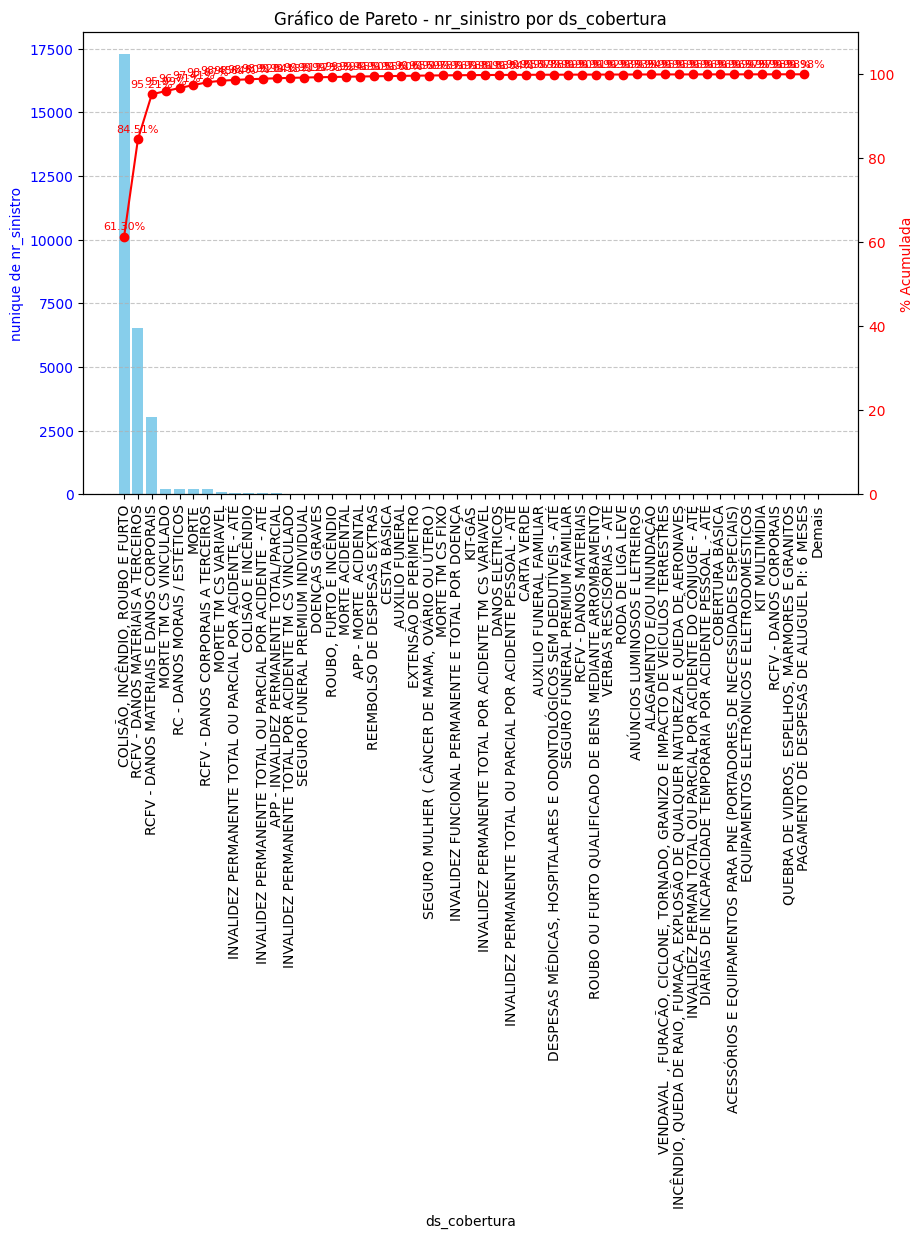

In [45]:
plot_pareto(
    df=df_sinistro,
    agrupa_por='ds_cobertura',
    campo_agrupado='nr_sinistro',
    tipo_agg='nunique',
    ds_tipo_agg='Número de Sinistros')